# Kaggle Toxic comment classification

In [1]:
!pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.7 MB/s eta 0:00:00


In [2]:
import os
import csv
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torchmetrics import AUROC, F1Score
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import torchtext.transforms as T
import torchdata.datapipes as dp
from torchtext import data
from torch.hub import load_state_dict_from_url
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy
import random
import collections
import time
from torch.utils.data import DataLoader, WeightedRandomSampler,SubsetRandomSampler

In [3]:
try:
    from google.colab import drive
    drive = drive.mount('/content/drive')
    data_dir = '/content/drive/My Drive/Dsba/04 M2 T1/Foundations of Deep Learning/Kaggle Competiton/toxic-comment-classification-dsba-2023/kaggle_data'
    drive_dir = '/content/drive/My Drive/Dsba/04 M2 T1/Foundations of Deep Learning/Kaggle Competiton/toxic-comment-classification-dsba-2023/'
    idle='gdrive'
except:
    idle='kaggle'
    data_dir = '/kaggle/input/toxic-comment-data/'
    drive_dir = '/kaggle/working/'


Mounted at /content/drive


In [4]:
# CPU or GPU device ?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cpu


In [5]:
torch.manual_seed(0)

## Configuration

In [111]:
saved_models = {
    'bert0': '/models/BERT/bert_model_V0.bin',
    'distilbert': '/models/BERT/DISTBert_model_epoch0.bin',
    'lstm0':'/models/LSTM/LSTM.bin',
    'lstm_yj':'/models/LSTM/LSTM_YJ.bin',
    'convnn0':'/models/CONVNN/kaggle_dataconvnn_2-model.pt'
}
model_params = {
    'bert0': {
        'MAX_SEQ_LENGTH': 220,
        'BATCH_SIZE': 32,
        'GRADIENT_ACCUMULATION_STEPS' : 1,
        'NUM_TRAIN_EPOCHS' : 10,
        'LEARNING_RATE' : 5e-5,
        'WARMUP_PROPORTION' : 0.1,
        'MAX_GRAD_NORM' : 5,
        'NUM_WORKERS' : 2,
        'PATIENCE': 3

    },
    'distilbert': {
        'MAX_SEQ_LENGTH': 512,
        'BATCH_SIZE': 16,
        'GRADIENT_ACCUMULATION_STEPS' : 1,
        'NUM_TRAIN_EPOCHS' : 2,
        'WARMUP_PROPORTION' : 0.1,
        'MAX_GRAD_NORM' : 5,
        'PATIENCE' :2,
        'MAX_LEN' : 512,
        'TRAIN_BATCH_SIZE' : 16,
        'EPOCHS' : 2,
        'LEARNING_RATE' : 1e-05,
        'NUM_WORKERS' : 2,
    },
    'convnn0':
     {
    'INPUT_DIM': 2500,
    'EMBEDDING_DIM': 100,
    'N_FILTERS': 100,
    'FILTER_SIZES': [3,4,5],
    'OUTPUT_DIM': 1,
    'DROPOUT':0.5,
    'LR': 5e-4
    },
    'lstm0':
     {
        'INPUT_DIM':40000,
        'EMBEDDING_DIM': 200,
        'HIDDEN_DIM':15,
        'N_LAYERS':1,
        'OUTPUT_DIM':1,
        'DROPOUT':0.5,
        'LR':1e-4,
        'BS': 64,
        'BI':False
    },
    'lstm_yj':
     {
        'INPUT_DIM':40000,
        'EMBEDDING_DIM': 300,
        'HIDDEN_DIM':45,
        'N_LAYERS':2,
        'OUTPUT_DIM':1,
        'DROPOUT':0.5,
        'LR':1e-4,
        'BS': 64,
        'N_EPOCHS' : 5,
        'BI':False
    }
                }
note_book_config ={
    'generate_augmented': False
}
args_denoise_custom = {
    'strip_html': False,
    'remove_stop':True,
    'stem_word': False,
    'remove_patterns': True,
    'lem_word': False,
}
models ={}

### Data cleaning:

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
def remove_stop_faster(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  return ' '.join(filtered_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def preprocess_string(s):
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

In [9]:
nlp = spacy.load("en_core_web_sm")
def remove_stop_w(text):
  doc = nlp(text)
  filtered_tokens = [token.text for token in doc if not token.is_stop]
  clean_text = ' '.join(filtered_tokens)
  return clean_text

In [10]:
from bs4 import BeautifulSoup
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()
import re

def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
  text = strip_html(text)
  # print(text)
  # text = remove_between_square_brackets(text)
  text = remove_special_characters(text)
  text = remove_brackets(text)
  text = remove_hyperlinks(text)
  text = remove_hashtags(text)
  text = preprocess_string(text)
  return text

def remove_special_characters(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  return text

def remove_brackets(text):
    # Define the regular expression pattern to match square brackets and their contents
    pattern = r'[\[\]]'

    # Use re.sub to replace matches with an empty string
    result = re.sub(pattern, '', text)

    return result
def remove_hyperlinks(text):
    # Remove hyperlinks using a regular expression
    return re.sub(r'http\S+', '', text)

def remove_hashtags(text):
    # Remove hashtags using a regular expression
    return re.sub(r'#\S+', '', text)

### Functions

In [11]:
def worst_group_accuracy(prediction, y, include_cr=False):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    # print(y)
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    if include_cr:
      for category in categories:
        for label in [0, 1]:
                  group = y.loc[y[category] == label]
                  group_preds = (group['pred'] > 0.5)
                  # Generate and print the classification report
                  report = classification_report(group['y'], group_preds)
                  print(f"Category: {category}_{label}")
                  print(report)
                  print("\n" + "="*40 + "\n")
    wga = np.min(accuracies)
    return wga

In [12]:
def evaluate_model(model, dataloader, criterion, cr =False):
    """
        Evaluate the model on a given dataloader.
        argument:
            model [torch.nn.Module]: model to evaluate
            dataloader [torch.utils.data.DataLoader]: dataloader on which to evaluate
            criterion [torch.nn.modules.loss]: desired loss to compute
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.eval()
    losses, predictions, indices = [], [], []
    for x, y, idx in tqdm(dataloader, leave=False):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy(), cr)
    return dataset_loss, dataset_metric, pred_df

## Miscelaneous

In [13]:
categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

### Functions

#### Class loss

Custom class loss for imbalanced categories

In [14]:
class LossComputer:
    def __init__(self, criterion, is_robust, dataset, alpha=None, gamma=0.1, adj=None, min_var_weight=0, step_size=0.01, normalize_loss=False, btl=False):
        self.groups = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
        self.criterion = criterion
        self.is_robust = is_robust
        self.gamma = gamma
        self.alpha = alpha
        self.min_var_weight = min_var_weight
        self.step_size = step_size
        self.normalize_loss = normalize_loss
        self.btl = btl

        self.n_groups = torch.tensor(8).to(device) #dataset.n_groups
        self.group_counts = torch.tensor([dataset[dataset[group]==1].shape[0] for group in self.groups]).to(device) # dataset.group_counts().to(device)
        self.group_frac = self.group_counts/self.group_counts.sum()
        self.group_str = self.groups #dataset.group_str

        if adj is not None:
            self.adj = torch.from_numpy(adj).float().to(device)
        else:
            self.adj = torch.zeros(self.n_groups).float().to(device)

        if is_robust:
            assert alpha, 'alpha must be specified'

        # quantities maintained throughout training
        self.adv_probs = torch.ones(self.n_groups).to(device)/self.n_groups
        self.exp_avg_loss = torch.zeros(self.n_groups).to(device)
        self.exp_avg_initialized = torch.zeros(self.n_groups).byte().to(device)

        self.reset_stats()

    def loss(self, yhat, y, group_idx=None, is_training=False):
        # compute per-sample and per-group losses
        per_sample_losses = self.criterion(yhat, y)
        group_loss, group_count = self.compute_group_avg(per_sample_losses, group_idx)
        # group_acc, group_count = self.compute_group_avg((torch.argmax(yhat,1)==y).float(), group_idx)
        group_acc, group_count = self.compute_group_avg(((yhat>0.5) ==y).float(), group_idx)
        # print(group_loss)
        # update historical losses
        self.update_exp_avg_loss(group_loss, group_count)

        # compute overall loss
        if self.is_robust and not self.btl:
            actual_loss, weights = self.compute_robust_loss(group_loss, group_count)
        elif self.is_robust and self.btl:
             actual_loss, weights = self.compute_robust_loss_btl(group_loss, group_count)
        else:
            actual_loss = per_sample_losses.mean()
            weights = None

        # update stats
        self.update_stats(actual_loss, group_loss, group_acc, group_count, weights)

        return actual_loss

    def compute_robust_loss(self, group_loss, group_count):
        adjusted_loss = group_loss
        if torch.all(self.adj>0):
            adjusted_loss += self.adj/torch.sqrt(self.group_counts)
        if self.normalize_loss:
            adjusted_loss = adjusted_loss/(adjusted_loss.sum())
        self.adv_probs = self.adv_probs * torch.exp(self.step_size*adjusted_loss.data)
        self.adv_probs = self.adv_probs/(self.adv_probs.sum())

        robust_loss = group_loss @ self.adv_probs
        return robust_loss, self.adv_probs

    def compute_robust_loss_btl(self, group_loss, group_count):
        adjusted_loss = self.exp_avg_loss + self.adj/torch.sqrt(self.group_counts)
        return self.compute_robust_loss_greedy(group_loss, adjusted_loss)

    def compute_robust_loss_greedy(self, group_loss, ref_loss):
        sorted_idx = ref_loss.sort(descending=True)[1]
        sorted_loss = group_loss[sorted_idx]
        sorted_frac = self.group_frac[sorted_idx]

        mask = torch.cumsum(sorted_frac, dim=0)<=self.alpha
        weights = mask.float() * sorted_frac /self.alpha
        last_idx = mask.sum()
        weights[last_idx] = 1 - weights.sum()
        weights = sorted_frac*self.min_var_weight + weights*(1-self.min_var_weight)

        robust_loss = sorted_loss @ weights

        # sort the weights back
        _, unsort_idx = sorted_idx.sort()
        unsorted_weights = weights[unsort_idx]
        return robust_loss, unsorted_weights

    def compute_group_avg(self, losses, group_idx):
        # compute observed counts and mean loss for each group
        group_map = (group_idx == torch.arange(self.n_groups).unsqueeze(1).long().to(device)).float()
        # print(group_map.shape)
        group_count = group_map.sum(1)
        # print(group_count.shape)
        group_denom = group_count + (group_count==0).float() # avoid nans
        # print("group_denom.shape",group_denom.shape)
        # print(losses.view(-1).shape)
        group_loss = (group_map @ losses.view(-1))/group_denom
        return group_loss, group_count

    def update_exp_avg_loss(self, group_loss, group_count):
        prev_weights = (1 - self.gamma*(group_count>0).float()) * (self.exp_avg_initialized>0).float()
        curr_weights = 1 - prev_weights
        self.exp_avg_loss = self.exp_avg_loss * prev_weights + group_loss*curr_weights
        self.exp_avg_initialized = (self.exp_avg_initialized>0) + (group_count>0)

    def reset_stats(self):
        self.processed_data_counts = torch.zeros(self.n_groups).to(device)
        self.update_data_counts = torch.zeros(self.n_groups).to(device)
        self.update_batch_counts = torch.zeros(self.n_groups).to(device)
        self.avg_group_loss = torch.zeros(self.n_groups).to(device)
        self.avg_group_acc = torch.zeros(self.n_groups).to(device)
        self.avg_per_sample_loss = 0.
        self.avg_actual_loss = 0.
        self.avg_acc = 0.
        self.batch_count = 0.

    def update_stats(self, actual_loss, group_loss, group_acc, group_count, weights=None):
        # avg group loss
        denom = self.processed_data_counts + group_count
        denom += (denom==0).float()
        prev_weight = self.processed_data_counts/denom
        curr_weight = group_count/denom
        self.avg_group_loss = prev_weight*self.avg_group_loss + curr_weight*group_loss

        # avg group acc
        self.avg_group_acc = prev_weight*self.avg_group_acc + curr_weight*group_acc

        # batch-wise average actual loss
        denom = self.batch_count + 1
        self.avg_actual_loss = (self.batch_count/denom)*self.avg_actual_loss + (1/denom)*actual_loss

        # counts
        self.processed_data_counts += group_count
        if self.is_robust:
            self.update_data_counts += group_count*((weights>0).float())
            self.update_batch_counts += ((group_count*weights)>0).float()
        else:
            self.update_data_counts += group_count
            self.update_batch_counts += (group_count>0).float()
        self.batch_count+=1

        # avg per-sample quantities
        group_frac = self.processed_data_counts/(self.processed_data_counts.sum())
        self.avg_per_sample_loss = group_frac @ self.avg_group_loss
        self.avg_acc = group_frac @ self.avg_group_acc

    def get_model_stats(self, model, args, stats_dict):
        model_norm_sq = 0.
        for param in model.parameters():
            model_norm_sq += torch.norm(param) ** 2
        stats_dict['model_norm_sq'] = model_norm_sq.item()
        stats_dict['reg_loss'] = args.weight_decay / 2 * model_norm_sq.item()
        return stats_dict

    def get_stats(self, model=None, args=None):
        stats_dict = {}
        for idx in range(self.n_groups):
            stats_dict[f'avg_loss_group:{idx}'] = self.avg_group_loss[idx].item()
            stats_dict[f'exp_avg_loss_group:{idx}'] = self.exp_avg_loss[idx].item()
            stats_dict[f'avg_acc_group:{idx}'] = self.avg_group_acc[idx].item()
            stats_dict[f'processed_data_count_group:{idx}'] = self.processed_data_counts[idx].item()
            stats_dict[f'update_data_count_group:{idx}'] = self.update_data_counts[idx].item()
            stats_dict[f'update_batch_count_group:{idx}'] = self.update_batch_counts[idx].item()

        stats_dict['avg_actual_loss'] = self.avg_actual_loss.item()
        stats_dict['avg_per_sample_loss'] = self.avg_per_sample_loss.item()
        stats_dict['avg_acc'] = self.avg_acc.item()

        # Model stats
        if model is not None:
            assert args is not None
            stats_dict = self.get_model_stats(model, args, stats_dict)

        return stats_dict

    def log_stats(self, logger, is_training):
        if logger is None:
            return

        logger.write(f'Average incurred loss: {self.avg_per_sample_loss.item():.3f}  \n')
        logger.write(f'Average sample loss: {self.avg_actual_loss.item():.3f}  \n')
        logger.write(f'Average acc: {self.avg_acc.item():.3f}  \n')
        for group_idx in range(self.n_groups):
            logger.write(
                f'  {self.group_str(group_idx)}  '
                f'[n = {int(self.processed_data_counts[group_idx])}]:\t'
                f'loss = {self.avg_group_loss[group_idx]:.3f}  '
                f'exp loss = {self.exp_avg_loss[group_idx]:.3f}  '
                f'adjusted loss = {self.exp_avg_loss[group_idx] + self.adj[group_idx]/torch.sqrt(self.group_counts)[group_idx]:.3f}  '
                f'adv prob = {self.adv_probs[group_idx]:3f}   '
                f'acc = {self.avg_group_acc[group_idx]:.3f}\n')
        logger.flush()

In [15]:
args = {
    'robust': True,
    'alpha': 0.02,
    'gamma': 0.1,
    'adjustments': None,
    'robust_step_size': 0.01,
    'use_normalized_loss': False,
    'btl':False,
    'minimum_variational_weight': 0
}

In [16]:
# Calculate epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Sampling functions

In [17]:
def get_weights_balanced(train_dataset, categories, n_samples, to_boost=['black', 'muslim', 'white'], value_boost=1.5):
    num_classes = 2
    class_sample_counts = train_dataset.label['y'].value_counts().values
    total_samples = class_sample_counts.sum()
    class_weights = {}
    cat_counts = {}
    cat_counts_y = {}
    y_weights = {}

    for category in categories:
        cat_counts_y[category] = {}
        y_weights[category] = {}
        cat_counts_y[category][1] = np.array([train_dataset.label[train_dataset.label[category] == 1]['y'].value_counts()[0], \
                                              train_dataset.label[train_dataset.label[category] == 1]['y'].value_counts()[1]
                                         ])
        cat_counts_y[category][0] = np.array([
                                    train_dataset.label[train_dataset.label[category] == 0]['y'].value_counts()[0], \
                                      train_dataset.label[train_dataset.label[category] == 0]['y'].value_counts()[1]
                                     ])

        cat_counts[category] = np.array([
                                train_dataset.label[category].value_counts()[0], \
                                train_dataset.label[category].value_counts()[1]
                               ])

        # Calculate class weights
        class_weights[category] = torch.Tensor(total_samples / (num_classes * cat_counts[category]))
        #normalize
        y_weights[category][0] = torch.Tensor(total_samples/ (num_classes * cat_counts_y[category][0]))
        y_weights[category][1] = torch.Tensor(total_samples/ (num_classes * cat_counts_y[category][1]))

        y_weights[category][0] = torch.Tensor(y_weights[category][0]/ y_weights[category][0].sum())
        y_weights[category][1] = torch.Tensor(y_weights[category][1]/ y_weights[category][1].sum())

        # Boost lows representative categories
        if category in to_boost:
            class_weights[category][1] *= value_boost
            y_weights[category][1] /= value_boost if value_boost != 0 else 1


    # Calculate general weights
    general_weights = torch.Tensor(total_samples / (num_classes * class_sample_counts))
    normalized_general_weights = general_weights / general_weights.sum()

    # Update the 'general' entry in class_weights
    class_weights['general'] = normalized_general_weights

    train_targets = train_dataset.label['y'].tolist()
    train_samples_weight = [
        torch.max(torch.Tensor([(class_weights[clase][valor] * y_weights[clase][valor][y]) for clase, valor in zip(categories, row)]))
        for y, row in zip(train_targets, train_dataset.label[categories].to_numpy())
    ]
    return train_samples_weight

In [18]:
def create_sampler_weight_some(train_dataset, categories, n_samples, to_boost=['black', 'muslim', 'white'], value_boost=1.5):
    num_classes = 2
    class_sample_counts = train_dataset.label['y'].value_counts().values
    total_samples = class_sample_counts.sum()
    class_weights = {}
    cat_counts = {}
    cat_counts_y = {}
    y_weights = {}

    for category in categories:
        cat_counts_y[category] = {}
        y_weights[category] = {}
        cat_counts_y[category][1] = np.array([train_dataset.label[train_dataset.label[category] == 1]['y'].value_counts()[0], \
                                              train_dataset.label[train_dataset.label[category] == 1]['y'].value_counts()[1]
                                         ])
        cat_counts_y[category][0] = np.array([
                                    train_dataset.label[train_dataset.label[category] == 0]['y'].value_counts()[0], \
                                      train_dataset.label[train_dataset.label[category] == 0]['y'].value_counts()[1]
                                     ])

        cat_counts[category] = np.array([
                                train_dataset.label[category].value_counts()[0], \
                                train_dataset.label[category].value_counts()[1]
                               ])

        # Calculate class weights
        class_weights[category] = torch.Tensor(total_samples / (num_classes * cat_counts[category]))
        y_weights[category][0] = torch.Tensor(total_samples/ (num_classes * cat_counts_y[category][0]))
        y_weights[category][1] = torch.Tensor(total_samples/ (num_classes * cat_counts_y[category][1]))

        y_weights[category][0] = torch.Tensor(y_weights[category][0]/ y_weights[category][0].sum())
        y_weights[category][1] = torch.Tensor(y_weights[category][1]/ y_weights[category][1].sum())

        # Boost lows representative categories
        if category in to_boost:
            class_weights[category][1] *= value_boost
            y_weights[category][1] /= value_boost if value_boost != 0 else 1

    # Calculate general weights
    general_weights = torch.Tensor(total_samples / (num_classes * class_sample_counts))
    normalized_general_weights = general_weights / general_weights.sum()

    # Update the 'general' entry in class_weights
    class_weights['general'] = normalized_general_weights

    train_targets = train_dataset.label['y'].tolist()

#     Calculate final sample weights
    train_samples_weight = [
        torch.max(torch.Tensor([(class_weights[clase][valor] * y_weights[clase][valor][y]) for clase, valor in zip(categories, row)]))
        for y, row in zip(train_targets, train_dataset.label[categories].to_numpy())
    ]

    train_sampler = WeightedRandomSampler(train_samples_weight, n_samples, replacement=True)
    return train_samples_weight

In [19]:
def create_sampler(train_dataset, categories, n_samples):
  num_classes = 2
  class_sample_counts = train_dataset.label['y'].value_counts().values
  total_samples = class_sample_counts.sum()
  class_weights = {}
  cat_counts={}
  cat_counts_y1 ={}
  cat_counts_y0 ={}
  cat_counts_y ={}
  y_weights ={}
  for category in categories:
    cat_counts_y[category] = {}
    y_weights[category] = {}
    cat_counts_y[category][1] = train_dataset.label[train_dataset.label[category]==1]['y'].value_counts().values
    cat_counts_y[category][0] = train_dataset.label[train_dataset.label[category]==0]['y'].value_counts().values
    cat_counts[category] = train_dataset.label[category].value_counts().values
    class_weights[category] = torch.Tensor(total_samples / (num_classes * cat_counts[category]))
    y_weights[category][0] = torch.Tensor(cat_counts[category].sum() / (num_classes * cat_counts_y[category][0]))
    y_weights[category][1] = torch.Tensor(cat_counts[category].sum() / (num_classes * cat_counts_y[category][1]))

  general_weights = torch.Tensor(total_samples / (num_classes * class_sample_counts))
  normalized_general_weights = general_weights / general_weights.sum()

  # Update the 'general' entry in class_weights
  class_weights['general'] = normalized_general_weights


  train_targets = train_dataset.label['y'].tolist()
  train_samples_weight = [
      torch.max(torch.Tensor([(class_weights[clase][valor]*y_weights[clase][valor][y]) for clase, valor in zip(categories, row)]))
      for y, row in zip(train_targets, train_dataset.label[categories].to_numpy())
  ]
  train_sampler = WeightedRandomSampler(train_samples_weight, n_samples, replacement=True)
  return train_sampler

In [20]:
def get_weights_balanced(train_dataset, categories, n_samples, to_boost=['black', 'muslim', 'white'], value_boost=1.5):
    num_classes = 2
    class_sample_counts = train_dataset.label['y'].value_counts().values
    total_samples = class_sample_counts.sum()
    class_weights = {}
    cat_counts = {}
    cat_counts_y = {}
    y_weights = {}

    for category in categories:
        cat_counts_y[category] = {}
        y_weights[category] = {}
        cat_counts_y[category][1] = np.array([train_dataset.label[train_dataset.label[category] == 1]['y'].value_counts()[0], \
                                              train_dataset.label[train_dataset.label[category] == 1]['y'].value_counts()[1]
                                         ])
        cat_counts_y[category][0] = np.array([
                                    train_dataset.label[train_dataset.label[category] == 0]['y'].value_counts()[0], \
                                      train_dataset.label[train_dataset.label[category] == 0]['y'].value_counts()[1]
                                     ])

        cat_counts[category] = np.array([
                                train_dataset.label[category].value_counts()[0], \
                                train_dataset.label[category].value_counts()[1]
                               ])

        # Calculate class weights
        class_weights[category] = torch.Tensor(total_samples / (num_classes * cat_counts[category]))

        y_weights[category][0] = torch.Tensor(total_samples/ (num_classes * cat_counts_y[category][0]))
        y_weights[category][1] = torch.Tensor(total_samples/ (num_classes * cat_counts_y[category][1]))

        y_weights[category][0] = torch.Tensor(y_weights[category][0]/ y_weights[category][0].sum())
        y_weights[category][1] = torch.Tensor(y_weights[category][1]/ y_weights[category][1].sum())

        # Boost lows representative categories
        if category in to_boost:
            class_weights[category][1] *= value_boost
            y_weights[category][1] /= value_boost if value_boost != 0 else 1

    # Calculate general weights
    general_weights = torch.Tensor(total_samples / (num_classes * class_sample_counts))
    normalized_general_weights = general_weights / general_weights.sum()

    # Update the 'general' entry in class_weights
    class_weights['general'] = normalized_general_weights
    train_targets = train_dataset.label['y'].tolist()
#     Calculate final sample weights
    train_samples_weight = [
        torch.max(torch.Tensor([(class_weights[clase][valor] * y_weights[clase][valor][y]) for clase, valor in zip(categories, row)]))
        for y, row in zip(train_targets, train_dataset.label[categories].to_numpy())
    ]
#     train_sampler = WeightedRandomSampler(train_samples_weight, n_samples, replacement=True)
    return train_samples_weight

In [21]:
def check_batch_dist(train_dataloader_balanced2, id_index = 2):
  for i, batch in tqdm(enumerate(train_dataloader_balanced2), leave=False):
      num_categories = len(categories)
      idx = batch[id_index]
      # Set up subplots
      fig, axes = plt.subplots(nrows=num_categories//3, ncols=3, figsize=(12, 3*num_categories))
      axes = axes.flatten()
      labels_tensor = batch[1]
      labels_np = labels_tensor.cpu().numpy()
      category_labels = train_dataloader_balanced2.dataset.label.iloc[idx]


      # print(train_dataset.label.iloc[idx].value_counts())
      unique_classes, class_counts = np.unique(labels_np, return_counts=True)
      print("Class Distribution:")
      for class_label, count in zip(unique_classes, class_counts):
          print(f"Class {class_label}: {count} samples")
      # Per category distribution
      # Category Distribution
      category_data = {}
      for j, category in enumerate(categories):
            category_counts = category_labels.groupby([category, 'y'])['y'].size().reset_index(name='count')

            # Create a subplot
            ax = axes[j] if num_categories > 1 else axes

            # Plot the bar chart for the current category
            sns.barplot(x=category, y='count', hue='y', data=category_counts, palette='pastel', ax=ax)

            # Set labels and title for each subplot
            ax.set_xlabel('Count')
            ax.set_ylabel('y')
            ax.set_title(f'Counts of y for {category}')

      # Show the plot after processing the first batch
      if i == 0:
          plt.tight_layout()
          plt.show()
          break

In [22]:
# Just a function to print the size of batch and elements in the batch
def check_datadimensions(data):
  print(len(data))
  for i in data.shape:
    print((data[i].shape))

### Exploring data

In [23]:
data_df = pd.read_csv(os.path.join(data_dir, f'train_x.csv'))
label_df = pd.read_csv(os.path.join(data_dir, f'train_y.csv'))
val_x_df = pd.read_csv(os.path.join(data_dir, f'val_x.csv'))
val_y_df = pd.read_csv(os.path.join(data_dir, f'val_y.csv'))
test_df = pd.read_csv(os.path.join(data_dir, f'test_x.csv'))
aug_x = pd.read_csv(os.path.join(data_dir, f'augmented_clean_x.csv'))
aug_y = pd.read_csv(os.path.join(data_dir, f'augmented_clean_y.csv'))
merged_df_train = pd.concat([data_df, label_df], axis =1)

 Histograms

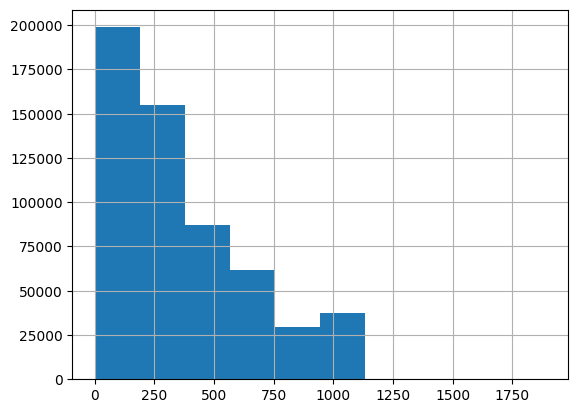

count    569438.000000
mean        363.880979
std         276.544812
min           1.000000
25%         143.000000
50%         280.000000
75%         532.000000
max        1891.000000
dtype: float64

In [24]:
rev_len = [len(i) for i in aug_x['string']]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Explore the target variable and categories

In [25]:
label_df.head().T

,0,1,2,3,4
male,0,1,0,0,0
female,0,1,0,0,0
LGBTQ,0,0,0,0,0
christian,0,0,0,0,0
muslim,0,0,0,0,0
other_religions,0,0,0,0,0
black,1,0,0,1,0
white,0,0,0,1,0
identity_any,1,1,0,1,0
severe_toxicity,0,0,0,0,0


In [26]:
label_df['y'].value_counts(normalize=True)

0    0.886577
1    0.113423
Name: y, dtype: float64

In [27]:
val_y_df['y'].value_counts(normalize=True)

0    0.888114
1    0.111886
Name: y, dtype: float64

In [28]:
def get_distribution_category(label_df):
  # List of categories
  categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
  result_df = pd.DataFrame(index=categories)
  percentages_1_0 = []
  percentages_1_1 = []
  percentages_0_0 = []
  percentages_0_1 = []
  # Iterate through each column in the DataFrame
  for column in label_df.columns:
      # Check if the column corresponds to the categories of interest
      if column in categories:
          # Calculate the percentage of occurrences of 1 for the current column
          percentage_1_0 = (label_df[(label_df[column] == 1) & (label_df['y'] == 0)][column].sum() / len(label_df)) * 100
          percentage_1_1 = (label_df[(label_df[column] == 1) & (label_df['y'] == 1)][column].sum() / len(label_df)) * 100
          percentage_0_0 = (label_df[(label_df[column] == 0 )& (label_df['y'] == 0)][column].count() / len(label_df)) * 100
          percentage_0_1 = (label_df[(label_df[column] == 0) & (label_df['y'] == 1)][column].count() / len(label_df)) * 100
          # Store the result in the result DataFrame
          result_df.loc[column, 'Percentage_1_0'] = percentage_1_0
          result_df.loc[column, 'Percentage_1_1'] = percentage_1_1
          result_df.loc[column, 'Percentage_0_0'] = percentage_0_0
          result_df.loc[column, 'Percentage_0_1'] = percentage_0_1
          # Append percentages to lists
  print(result_df)

In [29]:
get_distribution_category(aug_y)

                 Percentage_1_0  Percentage_1_1  Percentage_0_0  \
male                   6.416326        5.865432       50.545801   
female                 7.383420        5.360197       49.578707   
LGBTQ                  4.998086        5.413759       51.964042   
christian              7.098051        5.449584       49.864077   
muslim                 6.233866        7.508104       50.728262   
other_religions        5.969043       16.233198       50.993084   
black                  3.688549       20.491959       53.273579   
white                  5.712650       11.922632       51.249478   

                 Percentage_0_1  
male                  37.172440  
female                37.677675  
LGBTQ                 37.624114  
christian             37.588289  
muslim                35.529768  
other_religions       26.804674  
black                 22.545914  
white                 31.115240  


In [30]:
get_distribution_category(label_df)

                 Percentage_1_0  Percentage_1_1  Percentage_0_0  \
male                   9.431010        1.649209       79.226726   
female                11.627354        1.844349       77.030382   
LGBTQ                  2.287781        0.841889       86.369955   
christian              9.029208        0.909165       79.628528   
muslim                 4.025082        1.161546       84.632654   
other_religions        2.059560        0.372810       86.598176   
black                  2.521949        1.156342       86.135788   
white                  4.466284        1.740275       84.191453   

                 Percentage_0_1  
male                   9.693055  
female                 9.497915  
LGBTQ                 10.500375  
christian             10.433099  
muslim                10.180718  
other_religions       10.969454  
black                 10.185922  
white                  9.601989  


In [31]:
get_distribution_category(val_y_df)

                 Percentage_1_0  Percentage_1_1  Percentage_0_0  \
male                   8.964143        1.582559       79.847278   
female                11.332448        1.706507       77.478973   
LGBTQ                  2.432492        0.792386       86.378929   
christian              9.220894        0.849934       79.590527   
muslim                 3.536963        1.133245       85.274458   
other_religions        1.823816        0.358566       86.987605   
black                  2.476760        1.179726       86.334661   
white                  4.459938        1.885790       84.351483   

                 Percentage_0_1  
male                   9.606020  
female                 9.482072  
LGBTQ                 10.396193  
christian             10.338645  
muslim                10.055334  
other_religions       10.830013  
black                 10.008853  
white                  9.302789  


The data is unbalanced also per category, most of the data is in the category ==0 for each category

In [32]:
mask_all_zero = (label_df[categories] == 0).all(axis=1)
rows_with_all_zero = label_df[mask_all_zero]
print("Percentage with zeros in all categories: ",rows_with_all_zero.shape[0]/label_df.shape[0])

Percentage with zeros in all categories:  0.5981199681829332


59% of the data is not related to a group

In [33]:
rows_with_nozero = label_df[~mask_all_zero]

In [34]:
rows_with_nozero[rows_with_nozero[categories].sum(axis=1) >1]

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
3,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
8,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1
10,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
18,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269013,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
269025,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
269028,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1
269034,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1


Categories are not mutually exclusive, could be male and female at the same time, black and white, male and white. Etc

Almost 60% doesn't belong to any of the target groups

Data is imbalance to the 0 label, we should deal with it in the future.

In [35]:
sampled_rows = pd.DataFrame()
for category in categories:
    category_rows = merged_df_train[merged_df_train[category] == 1]
    if not category_rows.empty:
        sampled_row = category_rows.sample(1)
        sampled_rows = pd.concat([sampled_rows, sampled_row])

# Reset the index to remove the groupby structure
sampled_rows = sampled_rows.reset_index(drop=True)

# Display the sampled rows
print(sampled_rows['string'].values)

["You must have read a different article than I did. This is clearly a family grieving deeply for two members who they believe have fallen victim to mental illness. They provided insight and opted to acknowledge both victim and perpetrator as mentally ill to provided whatever sense there may be to what happened. I didn't see any back patting, any demands the boy go free. In fact they openly dispute his abuse claims and only say that his own mental illness and his mothers were a factor and explain a family effort predating the crime to help an ill member, including what is clearly now acknowledged as a flawed judgment call to send her youngest son to aide her. Perhaps you should re-read. What would you have them do? Call for a death penalty? Permanent incarceration with no mental health care? Pretend nothing was wrong before the crime?"
 "But inquiring liberals want to know what colour were her socks?  The outrage!!!\n\nTrudeau is known to wear stylish socks from skull and crossbones in

## Vocabulary

Create the tokenizer from different tokenizers,

In [36]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer.tokenize(text)
class Tokenizer:
    def __init__(self, tokenize_fn = 'basic_english', lower = True, max_length = None):

        self.tokenize_fn = torchtext.data.utils.get_tokenizer(tokenize_fn)
        self.lower = lower
        self.max_length = max_length

    def tokenize(self, s):

        tokens = self.tokenize_fn(s)

        if self.lower:
            tokens = [token.lower() for token in tokens]

        if self.max_length is not None:
            tokens = tokens[:self.max_length]

        return tokens

Define tokenizer from spacy and max lenght of 25000, this is the number of different tokens or different words in the data. Lets use 25000 which is recommended

In [37]:
max_length=40000 # Before 5000
tokenizer = Tokenizer('spacy', max_length=max_length)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


Testing the tokenizer

In [38]:
s = 'ham but don\'t not and'
tokens =tokenizer.tokenize(s)

Adding special tokens to the vocabulary and function to create a vocabulary from the data.

In [39]:
merged_x = pd.concat([data_df,val_x_df ])
merged_x['string'] =merged_x['string'].astype(str)
merged_x["string"] = merged_x["string"].str.lower()
merged_x["string"] = merged_x["string"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [40]:
specials = ['<pad>', '<sos>', '<eos>', '<unk>']
def build_vocab_from_data(data, tokenizer, **vocab_kwarg):

    vocab = build_vocab_from_iterator(yield_tokens(data), specials=specials, max_tokens = max_length)
    return vocab

Create a vocabulary from our train dataframe using the tokenizer setup before

In [41]:
vocab = build_vocab_from_data(merged_x['string'], tokenizer, max_length = max_length)
vocab.set_default_index(vocab['<unk>'])

##### Embedding

Using an already pretrained embedding helps the model to get sense from each token. Here I am using Glove embedding with 100 embedding dimensions. This will be loaded in the embedding layer of the Conv NN.

For more info about this method:
https://coderzcolumn.com/tutorials/artificial-intelligence/how-to-use-glove-embeddings-with-pytorch

Get Glove embedding 100 dimensions and get vecs from actual vocabulary

In [42]:
glove = torchtext.vocab.GloVe(name='42B', dim=300)

.vector_cache/glove.42B.300d.zip: 1.88GB [05:53, 5.32MB/s]                            
100%|█████████▉| 1917493/1917494 [06:04<00:00, 5267.79it/s]


Getting the embedding weights for the vocabulary we created.

In [43]:
pretrained_embeddings = glove.get_vecs_by_tokens(vocab.get_itos(), lower_case_backup=True)
pretrained_embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.5394, -0.1053,  0.0788,  ..., -0.0221, -0.4653,  0.0616],
        [ 0.3356, -0.0232, -0.3370,  ..., -0.6095, -0.5413,  0.0662],
        [-0.3214,  0.0988, -0.2670,  ..., -0.6317, -0.5616, -0.8752]])

Check the shape if it coinicides with the vocab size and embedding dimension.

In [44]:
pretrained_embeddings.shape

torch.Size([40000, 300])

This is the vectorizer pipeline, so first tokenize the string, then get the vocabulary

In [45]:
# text_pipeline = lambda x: pretrained_embeddings[vocab(tokenizer.tokenize(x))]
text_pipeline = lambda x: vocab(tokenizer.tokenize(x))
# Another pipeline for the LSTM
text_pipeline_lstm = lambda x: vocab(tokenizer.tokenize(x))

Testing the vectorizer

In [46]:
text_pipeline('I how are you, I am Javier')

[15, 73, 19, 17, 6, 15, 157, 3]

In [47]:
print(f'Unique words in vocab: {len(vocab)}')

Unique words in vocab: 40000


#### Collate batch function

This function is used by the data loader to prepare the data per batch. Necessary to apply some transformations per batch

In [48]:
class Collator:
    def __init__(self, pad_idx):

        self.pad_idx = pad_idx

    def collate(self, batch):
        text, labelsl, idxs = zip(*batch)
        labels = torch.tensor(labelsl, dtype=torch.int64)
        # print(text.dtype)
        text = nn.utils.rnn.pad_sequence(text, padding_value=self.pad_idx, batch_first=True)
        idx_list = torch.tensor(idxs, dtype=torch.int64)
        return text, labels, idx_list

In [49]:
class CollatorLSTM:
    def __init__(self, pad_idx):

        self.pad_idx = pad_idx

    def collate(self, batch):
        text, labelsl, idxs, g = zip(*batch)
        labels = torch.tensor(labelsl, dtype=torch.int64)
        # print(text.dtype)
        text = nn.utils.rnn.pad_sequence(text, padding_value=self.pad_idx, batch_first=True)
        idx_list = torch.tensor(idxs, dtype=torch.int64)
        g_list = torch.tensor(g, dtype=torch.int64)
        return text, labels, idx_list, g_list

### Data Augmentation

In [50]:
!pip install nlpaug --quiet

In [51]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [52]:
!pip install -U sacremoses --quiet

In [53]:
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', aug_p=0.3, model_type='bert', device=device)
aug_syn = naw.SynonymAug(aug_src='wordnet', lang='eng')
aug_rnd = nac.RandomCharAug(action="insert")
def create_augmented(text, n=1):
  augmented_text = aug.augment(text, n)
  augmented_text = aug_syn.augment(text)
  augmented_text = aug_rnd.augment(text)
  # augmented_text = back_translation_aug.augment(text)
  return augmented_text[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [54]:
text = 'I always find the Star Wars/Star Trek debate funny because they seem so different to me that I have a hard time understanding how the two can be compared. Star Trek was created as a series of books and an episodic TV show, meaning that it was meant to have discreet stories told and wrapped up in a short time. Star Wars, on the other hand, was written as a series of movies with a far-reaching storyline. Star Trek is meant to be set in our own future, complete with our history and built upon our understanding of the real universe. Star Wars, however, exists "a long time ago, in a galaxy far, far away." That opens SW up to potentially involve elements that would be too fantastical in a universe based on our own, no matter how futuristic. There are many other reasons, but fundamentally, comparing SW and ST does not seem like an appropriate comparison. (Also, if you insist on comparing them, it would probably be best to be done by someone with a reasonable degree of knowledge of both properties.)'
augmented_text = create_augmented(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
I always find the Star Wars/Star Trek debate funny because they seem so different to me that I have a hard time understanding how the two can be compared. Star Trek was created as a series of books and an episodic TV show, meaning that it was meant to have discreet stories told and wrapped up in a short time. Star Wars, on the other hand, was written as a series of movies with a far-reaching storyline. Star Trek is meant to be set in our own future, complete with our history and built upon our understanding of the real universe. Star Wars, however, exists "a long time ago, in a galaxy far, far away." That opens SW up to potentially involve elements that would be too fantastical in a universe based on our own, no matter how futuristic. There are many other reasons, but fundamentally, comparing SW and ST does not seem like an appropriate comparison. (Also, if you insist on comparing them, it would probably be best to be done by someone with a reasonable degree of knowledge of b

#### Generate augmented rows in the train

In this section, we generated some augmented data to balance the categories.

In [55]:
def create_new_data(train_dataset, n_samples):
  num_classes = 2
  class_sample_counts = train_dataset['y'].value_counts().values
  total_samples = class_sample_counts.sum()
  class_weights = {}
  cat_counts={}
  cat_counts_y1 ={}
  cat_counts_y0 ={}
  cat_counts_y ={}
  y_weights ={}
  to_create ={}
  label_df = train_dataset
  categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
  augmented_data = pd.DataFrame(columns=label_df.columns)
  for category in categories:
    cat_counts_y[category] = {}
    y_weights[category] = {}
    cat_counts_y[category][1] = train_dataset[(train_dataset[category]==1)]['y'].value_counts().values
    cat_counts[category] = train_dataset[train_dataset[category]==1].shape[0]

  for category in categories:
    to_create[category] = int(max(cat_counts.values()) - cat_counts[category])

  print(to_create)
  return cat_counts


#### Create csv from augmented data

In [56]:
if(note_book_config['generate_augmented']):
  # First we get how many records to create per category group/
  data_to_create = create_new_data(aug_y,2)
  to_create = ['black','other_religions','white']
  augmented_data = pd.DataFrame(columns=merged_df_train.columns)
  # Now, we use the function create_augmented to create new rows per category.
  for cat in to_create:
    data_to_copy = merged_df_train[merged_df_train[cat] == 1]
    # Copy more y data == 1
    data_to_copy = data_to_copy[data_to_copy['y']==1]
    for n in tqdm(range(0, data_to_create[cat], 100)):
      underrepresented_samples = data_to_copy.sample(100, replace=True)
      underrepresented_samples['string'] = underrepresented_samples['string'].apply(create_augmented)
      augmented_data = pd.concat([augmented_data, underrepresented_samples])
      augmented_data.to_csv(data_dir+ f'/augmented/{cat}.csv')


Concatenate and save the generated data

In [57]:
if(note_book_config['generate_augmented']):
  dfs = []
  data_df = pd.read_csv(os.path.join(data_dir, f'train_x.csv'),index_col=0)
  label_df = pd.read_csv(os.path.join(data_dir, f'train_y.csv'))
  csv_files = [file for file in os.listdir(drive_dir+'/kaggle_data/augmented/last/') if file.endswith('.csv')]
  for csv_file in csv_files:
      file_path = os.path.join(drive_dir+'/kaggle_data/augmented/last/', csv_file)
      df = pd.read_csv(file_path, index_col=1, usecols=lambda x: x not in [0])
      dfs.append(df)

  concatenated_df = pd.concat(dfs, ignore_index=True)
  concatenated_df.reset_index(drop=True, inplace=True)
  concatenated_df.iloc[:, 1] = concatenated_df.iloc[:, 1].astype(str)
  concatenated_df.iloc[:, 1] = concatenated_df.iloc[:, 1].apply(denoise_text)
  #Concatenate both
  aug_df = pd.read_csv(os.path.join(data_dir, f'augmented_x.csv'),index_col=0)
  aug_label_df = pd.read_csv(os.path.join(data_dir, f'augmented_y.csv'))
  df_x_augm = pd.concat([concatenated_df[aug_df.columns], aug_df])
  df_y_augm = pd.concat([concatenated_df[aug_label_df.columns], aug_label_df])

  df_x_augm.to_csv(drive_dir+'/kaggle_data/aug_x.csv', index=True)
  df_y_augm.to_csv(drive_dir+'/kaggle_data/aug_y.csv', index=False)

## ConvNN Model


#### Dataset

In [69]:
class JaviDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None):
        super(JaviDataset, self).__init__()
        assert mode in ['train', 'val', 'test', 'augmented']
        self.mode = mode

        # load the data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)

        #clean data
        self.data.iloc[:, 0] = self.data.iloc[:, 0].apply(denoise_text)

        # load the labels if not the test set
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # train the vectorizer if train set
        if self.mode in ['train','augmented']:
            self.vectorizer = vectorizer
            # self.vectorizer.fit(self.data.values.flatten().tolist())
        # otherwise use the vectorizer given as arguments (which was trained on the train set)
        else:
            self.vectorizer = vectorizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data.iloc[idx, 0]
        x = self.vectorizer(x)
        # print(x)
        x = torch.tensor(x).int()
        if self.mode == 'test':
            return x, idx, idx
        else:
            y = torch.tensor([self.label.iloc[idx]['y']], dtype=torch.int64)
            return x, y, idx

#### Model

Convolutional neural networw with an embedding layer.
Different filters and filter sizes.

In [88]:
class JaviClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.embeddingBag = nn.EmbeddingBag(vocab_size, embedding_dim, padding_idx = pad_idx,sparse=True,)
        self.filter_sizes = filter_sizes
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #text = [batch size, sent len]

        embedded = self.embedding(x)

        embedded = embedded.unsqueeze(1)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim = 1))
        ret = self.fc(cat)
        # x = F.sigmoid(cat)
        return F.sigmoid(ret)

Here testing the conv NN model

In [71]:
def train_model_conv(model, optimizer, criterion, dataloader):
    """
        Train a model for one epoch.
        arguments:
            model [torch.nn.Module]: model to evaluate
            oprimizer [torch.optim]: optimizer used for training
            criterion [torch.nn.modules.loss]: desired loss to compute
            dataloader [torch.utils.data.DataLoader]: dataloader used for training
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.train()
    losses, predictions, indices = [], [], []
    for x, y, idx in tqdm(dataloader, leave=False):
        x, y = x.to(device).int(), y.to(device)
        optimizer.zero_grad()
        if(x.shape[1] > max(model.filter_sizes)):
          pred = model(x)
          loss = criterion(pred.squeeze(1), y.float())
          loss.backward()
          optimizer.step()
          losses.extend([loss.item()] * len(y))
          predictions.extend(pred.detach().squeeze().tolist())
          indices.extend(idx.tolist())


    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy())
    return dataset_loss, dataset_metric, losses

#### Train

In [72]:
train_dataset2 = JaviDataset(data_dir, 'train', text_pipeline)
val_dataset2 = JaviDataset(data_dir, 'val', train_dataset2.vectorizer )

<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup =

Create a collator

In [74]:
PAD_IDX = vocab.get_stoi()["<unk>"]
collator = Collator(PAD_IDX)

In [75]:
# train_dataloader_bal_pro = DataLoader(train_dataset2, batch_size=32,,collate_fn=collator.collate)
train_dataloader_bal_pro = DataLoader(train_dataset2, batch_size=32, shuffle=True, collate_fn=collator.collate)

In [80]:
INPUT_DIM = model_params['convnn0']['INPUT_DIM']
EMBEDDING_DIM = model_params['convnn0']['EMBEDDING_DIM']
N_FILTERS = model_params['convnn0']['N_FILTERS']
FILTER_SIZES = model_params['convnn0']['FILTER_SIZES']
OUTPUT_DIM = model_params['convnn0']['OUTPUT_DIM']
DROPOUT = model_params['convnn0']['DROPOUT']
LR = model_params['convnn0']['LR']

criterion = nn.BCELoss().to(device)

model = JaviClassifier(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX).to(device)
N_EPOCHS = 10
best_valid_loss = float('inf')
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)

Preload embeddings from the Glove embeddings

In [81]:
model.embedding.load_state_dict({'weight': pretrained_embeddings})

<All keys matched successfully>

initialize specials with random

In [82]:
PAD_IDX_s = [vocab.get_stoi()[special] for special in specials]

In [83]:
pretrained_embeddings[PAD_IDX_s] = torch.randn((EMBEDDING_DIM, ))

In [84]:
val_dataloader_pro = DataLoader(val_dataset2, batch_size=32, collate_fn=collator.collate)

Train

In [85]:
PATIENCE = 5
MODEL_FILE_NAME = 'kaggle_dataconvnn_2-model.pt'

In [ ]:
loss_history = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_metric, losses = train_model_conv(model, optimizer, criterion, train_dataloader_bal_pro)
    mlp_val_loss, mlp_val_metric, pred_df = evaluate_model(model, val_dataloader_pro, criterion, False)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | WG Acc: {train_metric*100:.2f}%')
    print(f'\tVal Loss: {mlp_val_loss:.3f} | WG Acc: {mlp_val_metric*100:.2f}%')
    if len(loss_history) == 0 or mlp_val_loss < min(loss_history):
        no_improvement = 0
        torch.save(model.state_dict(),  os.path.join(drive_dir, MODEL_FILE_NAME))
    else:
        no_improvement += 1
    # if no_improvement >= PATIENCE:
    #     print("No improvement on development set. Finish training.")
    #     break
    loss_history.append(mlp_val_loss)

Save the model state

In [ ]:
torch.save(model.state_dict(), data_dir+'convnn_2-model.pt')

#### Test

In [ ]:
mlp_val_loss, mlp_val_metric, pred_df = evaluate_model(model, val_dataloader_pro, criterion, True)
print(f'MLP classifier validation loss {mlp_val_loss:.4f} WGA {mlp_val_metric:.4f}')

  0%|          | 0/1412 [00:00<?, ?it/s]

Category: male_0
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     36075
           1       0.37      0.60      0.46      4340

    accuracy                           0.85     40415
   macro avg       0.66      0.74      0.69     40415
weighted avg       0.89      0.85      0.86     40415



Category: male_1
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4050
           1       0.43      0.53      0.48       715

    accuracy                           0.83      4765
   macro avg       0.67      0.70      0.69      4765
weighted avg       0.84      0.83      0.83      4765



Category: female_0
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     35005
           1       0.38      0.60      0.46      4284

    accuracy                           0.85     39289
   macro avg       0.66      0.74      0.69     39289
weighted avg     

## LSTM

In [50]:
def evaluate_model_LSTM(model, dataloader, criterion, cr =False):
    """
        Evaluate the model on a given dataloader.
        argument:
            model [torch.nn.Module]: model to evaluate
            dataloader [torch.utils.data.DataLoader]: dataloader on which to evaluate
            criterion [torch.nn.modules.loss]: desired loss to compute
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.eval()
    losses, predictions, indices = [], [], []
    for x, y, idx, g in tqdm(dataloader, leave=False):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy(), cr)
    return dataset_loss, dataset_metric, pred_df

### Dataset

In [51]:
class LSTMDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None):
        super(LSTMDataset, self).__init__()
        assert mode in ['train', 'val', 'test', 'augmented', 'augmented_clean','combined']
        self.mode = mode
        self.groups = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
        # load the data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)
        if(mode != 'augmented_clean'):
            #clean data
            self.data.iloc[:, 0] = self.data.iloc[:, 0].apply(denoise_text)
            #remove stop words
            self.data.iloc[:, 0] = self.data.iloc[:, 0].apply(remove_stop_faster)
        # load the labels if not the test set
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # train the vectorizer if train set
        if self.mode in ['train','augmented','augmented_clean','combined']:
            self.vectorizer = vectorizer
        # otherwise use the vectorizer given as arguments (which was trained on the train set)
        else:
            self.vectorizer = vectorizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data.iloc[idx, 0]
        x = self.vectorizer(str(x))
        # print(x)
        x = torch.tensor(x).int()
        if self.mode == 'test':
            return x, idx, idx
        else:
            y = torch.tensor([self.label.iloc[idx]['y']], dtype=torch.int64)
            # g = [1 if self.label.iloc[idx][group] == 1 else 0 for i, group in enumerate(self.groups) ]
            g_index = next((i for i, group in enumerate(self.groups) if self.label.iloc[idx][group] == 1), None)

            # Check if a match was found
            if g_index is not None:
                g = torch.tensor(g_index, dtype=torch.int64)
            else:
                # Handle the case where no match was found
                g = torch.tensor(-1, dtype=torch.int64)  # Set to -1 or any default value
            return x, y, idx, g


### Model

In [73]:
# Define the model
class LSTM(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, dropout=0, drop_layer =False, pad_idx=3, bi=False, **args):
        super(LSTM, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.dropout = dropout
        self.droplayer = drop_layer
        self.bi = bi

        self.embed = nn.Embedding(self.V, self.D, padding_idx = pad_idx)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            dropout=self.dropout,
            bidirectional = self.bi,
            batch_first=True)
        self.drop_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(self.M, self.K)
        self.sig = nn.Sigmoid()

    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out = self.embed(X)

        # get RNN unit output
        out, _ = self.rnn(out, (h0, c0))

        # max pool
        out, _ = torch.max(out, 1)

        # we only want h(T) at the final time step
        out = self.fc(out)
        return F.sigmoid(out)

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.L,batch_size,self.M)).to(device)
        c0 = torch.zeros((self.L,batch_size,self.M)).to(device)
        hidden = (h0,c0)
        return hidden

In [53]:
# LSTM Model which keep track of the hidden state of last batch
class LSTM_Track(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, dropout=0, drop_layer =False, pad_idx=3, bi=False):
        super(LSTM, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.dropout = dropout
        self.droplayer = drop_layer
        self.bi = bi

        self.embed = nn.Embedding(self.V, self.D, padding_idx = pad_idx)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            dropout=self.dropout,
            bidirectional = self.bi,
            batch_first=True)
        self.drop_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(self.M, self.K)
        self.sig = nn.Sigmoid()

    def forward(self, X, hidden):
#         h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
#         c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        batch_size = X.size(0)
        embeds = self.embed(X)
        #For last batch of less than batch size
        if(hidden[0].size(1) != embeds.size(0)):
            h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
            c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
            hidden = (h0, c0)
        # get RNN unit output

#         print(hidden)
        lstm_out, hidden = self.rnn(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.M)

        if(self.droplayer):
            lstm_out = self.drop_layer(lstm_out)

#         # max pool
#         out, _ = torch.max(out, 1)
        # we only want h(T) at the final time step
        out = self.fc(lstm_out)
#         Sigmoid
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.L,batch_size,self.M)).to(device)
        c0 = torch.zeros((self.L,batch_size,self.M)).to(device)
        hidden = (h0,c0)
        return hidden

In [91]:
def train_model_lstm(model, optimizer, criterion, dataloader):
    """
        Train a model for one epoch.
        arguments:
            model [torch.nn.Module]: model to evaluate
            oprimizer [torch.optim]: optimizer used for training
            criterion [torch.nn.modules.loss]: desired loss to compute
            dataloader [torch.utils.data.DataLoader]: dataloader used for training
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.train()
    losses, predictions, indices = [], [], []
    for x, y, idx in tqdm(dataloader, leave=False):
        x, y = x.to(device).int(), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(1), y.float())
        loss.backward()
        optimizer.step()
        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())


    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy())
    return dataset_loss, dataset_metric, losses

In [92]:
def train_model_lstm_custom(model, optimizer, criterion, dataloader, custom_loss=True):
    """
        Train a model for one epoch.
        arguments:
            model [torch.nn.Module]: model to evaluate
            oprimizer [torch.optim]: optimizer used for training
            criterion [torch.nn.modules.loss]: desired loss to compute
            dataloader [torch.utils.data.DataLoader]: dataloader used for training
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.train()
    losses, predictions, indices = [], [], []
    for x, y, idx, g in tqdm(dataloader, leave=False):
        x, y,g = x.to(device).int(), y.to(device), g.to(device)
        optimizer.zero_grad()
        pred = model(x)
        if(custom_loss):
            loss = criterion.loss(pred.squeeze(1), y.float(), g, True)
        else:
            loss = criterion(pred.squeeze(1), y.float())
        loss.backward()
        optimizer.step()
        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())


    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy())
    return dataset_loss, dataset_metric, losses

#### Train

In [54]:
BS = model_params['lstm_yj']['BS']
N_EPOCHS = model_params['lstm_yj']['N_EPOCHS']
MODEL_FILE_NAME = 'LSTM_DRO_.bin'
EMBEDDING_DIM =  model_params['lstm_yj']['EMBEDDING_DIM']
DROPOUT = model_params['lstm_yj']['DROPOUT']
LR = model_params['lstm_yj']['LR']
HIDDEN_DIM = model_params['lstm_yj']['HIDDEN_DIM']
NLAYERS = model_params['lstm_yj']['N_LAYERS']
BI = model_params['lstm_yj']['BI']

In [94]:
criterion = nn.BCELoss().to(device)
model = LSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NLAYERS, 1,DROPOUT)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#initialize embedded layer
model.embed.load_state_dict({'weight': pretrained_embeddings})
pad_token = '<PAD>'
pad_idx = vocab[pad_token]
PAD_IDX_s = [vocab.get_stoi()[special] for special in specials]
pretrained_embeddings[PAD_IDX_s] = torch.randn((EMBEDDING_DIM, ))

In [95]:
collator = CollatorLSTM(pad_idx)
collatorVal = Collator(pad_idx)

In [99]:
# train_dataset2 = JaviDataset(data_dir, 'train')
# val_dataset2 = JaviDataset(data_dir, 'val', train_dataset2.vectorizer )
# Augmented data
train_dataset2 = LSTMDataset(data_dir, 'combined', text_pipeline_lstm)
val_dataset2 = LSTMDataset(data_dir, 'val', train_dataset2.vectorizer )

<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-12-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup =

In [101]:

# Assuming len(train_ds) is the total number of samples in your dataset
total_samples = len(train_dataset2)
subset_size = 10
# Create a random subset sampler
subset_sampler = SubsetRandomSampler(range(subset_size))

In [102]:
# train_dataloader_bal = DataLoader(train_dataset2, batch_size=BS, sampler=train_sampler,collate_fn=collator.collate)
train_dl_short = DataLoader(train_dataset2, batch_size=BS, sampler=subset_sampler,collate_fn=collator.collate)
train_dataloader_shuffled = DataLoader(train_dataset2, batch_size=BS, shuffle=True,collate_fn=collator.collate)
val_dataloader_pro = DataLoader(val_dataset2, batch_size=BS, collate_fn=collator.collate)

In [ ]:
loss_history = []
val_metric = []
CLIP = 5
for epoch in range(N_EPOCHS):
    model.train()
    # initialize hidden state
    start_time = time.time()
    #Train loop
    # train_loss, train_metric, losses = train_model_lstm_custom(model, optimizer, criterion, train_dl_short, False)
    train_loss, train_metric, losses = train_model_lstm_custom(model, optimizer, criterion, train_dataloader_shuffled, False)
    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    optimizer.step()
    # Validation loop
    #mlp_val_loss, mlp_val_metric, pred_df = evaluate_model_LSTM(model, val_dataloader_pro, criterion, False)
#     mlp_val_loss, mlp_val_metric, pred_df = evaluate_model_LSTM(model, valataloader_bal_sampled, criterion, False)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | WG Acc: {train_metric*100:.2f}%')
    #print(f'\tVal Loss: {mlp_val_loss:.3f} | WG Acc: {mlp_val_metric*100:.2f}%')

## BERT V0

In [55]:
# Setup the batch size, recommended 16, 32
BATCH_SIZE = model_params['bert0']['BATCH_SIZE']
MAX_SEQ_LENGTH =   model_params['bert0']['MAX_SEQ_LENGTH']
GRADIENT_ACCUMULATION_STEPS =  model_params['bert0']['GRADIENT_ACCUMULATION_STEPS']
NUM_TRAIN_EPOCHS =  model_params['bert0']['NUM_TRAIN_EPOCHS']
WARMUP_PROPORTION = model_params['bert0']['WARMUP_PROPORTION']
MAX_GRAD_NORM = model_params['bert0']['MAX_GRAD_NORM']
PATIENCE =model_params['bert0']['PATIENCE']
MAX_LEN = model_params['bert0']['MAX_SEQ_LENGTH']
TRAIN_BATCH_SIZE = model_params['bert0']['BATCH_SIZE']
EPOCHS = model_params['bert0']['NUM_TRAIN_EPOCHS']
LEARNING_RATE = model_params['bert0']['LEARNING_RATE']
NUM_WORKERS = model_params['bert0']['NUM_WORKERS']

### Some functions

In [56]:
def train_BERT( model, optimizer, criterion, dataloader, scheduler,GRADIENT_ACCUMULATION_STEPS):
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  losses, predictions, indices = [], [], []
  for step, batch in enumerate(tqdm(dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids, idxs = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids.float())
        loss = outputs[0]
        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()
        pred = np.argmax(outputs['logits'].detach().to('cpu'), axis=1)
        losses.extend([loss.item()] * len(label_ids))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idxs.tolist())
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
  pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
  dataset_loss = np.mean(losses)
  dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy())
  gc.collect()
  torch.cuda.empty_cache()
  return dataset_loss, dataset_metric, losses

In [57]:
def evaluate_BERT_model(model, dataloader, criterion, cr =False):
    """
        Evaluate the model on a given dataloader.
        argument:
            model [torch.nn.Module]: model to evaluate
            dataloader [torch.utils.data.DataLoader]: dataloader on which to evaluate
            criterion [torch.nn.modules.loss]: desired loss to compute
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.eval()
    losses, predictions, indices = [], [], []
    eval_loss = 0
    nb_eval_steps = 0
    for batch in tqdm(dataloader, leave=False):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, y, idx = batch

        with torch.no_grad():
          res = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=y)

        pred = np.argmax(res['logits'].to('cpu'), axis=1)
        # loss = criterion(pred.squeeze().to(device), y.squeeze())
        eval_loss += res['loss'].mean().item()
        nb_eval_steps += 1

        losses.extend([res['loss'].mean().item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())
    eval_loss = eval_loss / nb_eval_steps
    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy(), cr)
    return dataset_loss, dataset_metric, pred_df

#### Model

In [58]:
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertForSequenceClassification

In [59]:
BERT_MODEL ='bert-base-uncased'

### Model definition

In [60]:
## BERT
tokenizer_bert = BertTokenizer.from_pretrained(BERT_MODEL)
model = BertModel.from_pretrained(BERT_MODEL)
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Dataset

Not using this by now, I was thinking on changing for a more eficient data loader thant the function get_data_loader

In [106]:
#Working on it, still not rready
class BertDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None, max_seq_length=100):
        super(BertDataset, self).__init__()
        assert mode in ['train', 'val', 'test', 'augmented', 'augmented_clean','combined']
        self.mode = mode
        self.max_seq_length = max_seq_length
        # load the data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)

        # load the labels if not the test set
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # train the vectorizer if train set
        if self.mode in ['train','augmented', 'augmented_clean','combined']:
            self.vectorizer = vectorizer
            # self.vectorizer.fit(self.data.values.flatten().tolist())
        # otherwise use the vectorizer given as arguments (which was trained on the train set)
        else:
            self.vectorizer = vectorizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = str(self.data.iloc[idx, 0])
        x = " ".join(x.split())
        inputs = self.vectorizer.encode_plus(
            x,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_length,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'id': idx
        }
        if self.mode != 'test':
          output['targets'] = torch.tensor(self.label.iloc[idx]['y'], dtype=torch.float)

        return output

In [65]:
train_ds = BertDataset(data_dir, 'train', tokenizer_bert, MAX_SEQ_LENGTH)
# val_ds = BertDataset(data_dir, 'val', tokenizer_bert, MAX_SEQ_LENGTH)
test_ds = BertDataset(data_dir, 'test', train_ds.vectorizer, MAX_SEQ_LENGTH)

Data Loader

In [66]:
# Assuming len(train_ds) is the total number of samples in your dataset
total_samples = len(train_ds)
subset_size = 10
# Create a random subset sampler
subset_sampler = SubsetRandomSampler(range(subset_size))

In [67]:
# DataLoader(train_dataset2, batch_size=256, sampler=train_sampler,collate_fn=collator.collate)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,num_workers=4)
train_dl_short = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=subset_sampler,num_workers=4)
# dev_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
# dev_dl_short = DataLoader(val_ds, batch_size=BATCH_SIZE, sampler=subset_sampler)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Dataloader

### Functions Eval

In [68]:
def evaluateBert(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []
    with torch.inference_mode():
      for step, data in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
          ids = data['ids'].to(device, dtype=torch.long)
          mask = data['mask'].to(device, dtype=torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
          label_ids = data['id'].to(device, dtype=torch.long)
          targets = data['targets'].to(device, dtype = torch.float)

          outputs = model(ids, mask, token_type_ids)
          probas = torch.sigmoid(outputs)
          loss = nn.BCEWithLogitsLoss()(outputs.squeeze(1), targets)
          label_ids = label_ids.to('cpu').numpy()
          predicted_labels += list(probas)
          correct_labels += list(targets)

          eval_loss += loss.item()
          nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels.to('cpu'))
    predicted_labels = np.array(predicted_labels.to('cpu'))

    return eval_loss, correct_labels, predicted_labels

### Train

In [69]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

In [70]:
num_train_steps = int(len(train_dl.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
criterion = nn.BCEWithLogitsLoss()

Checking the data loader

In [ ]:
import os
from tqdm import trange
from sklearn.metrics import classification_report, precision_recall_fscore_support
NUM_TRAIN_EPOCHS = 3
OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "bert_model_V0.bin"
PATIENCE = 3
DL = train_dl_short
# DL = train_dl
# DL = train_dl
loss_history = []
no_improvement = 0
i=0
for epoch in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(DL, desc="Training iteration")):
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        print(loss)
        loss = outputs[0]
        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS
        loss.backward()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
    # dev_loss, _, _ = evaluateBert(model, dev_dl)
    # dev_loss, _, _ = evaluateBert(model, dev_dl_short)

    print("Loss history:", loss_history)
    # print("Dev loss:", dev_loss)
    # print("Train loss:", tr_loss.to('cpu')/int(NUM_TRAIN_EPOCHS))

    if len(loss_history) == 0 or loss.item() < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(drive_dir, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break
    i +=1
    loss_history.append(loss.item())

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and 

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model
MODEL_FILE_NAME ="bert_model_V0.bin"
output_model_file = os.path.join(drive_dir + "models/", MODEL_FILE_NAME)
torch.save(model_to_save.state_dict(), output_model_file)

## BERT DISTI

In [62]:
# Setup parameters
BATCH_SIZE = model_params['distilbert']['BATCH_SIZE']
MAX_SEQ_LENGTH = model_params['distilbert']['MAX_SEQ_LENGTH']
GRADIENT_ACCUMULATION_STEPS = model_params['distilbert']['GRADIENT_ACCUMULATION_STEPS']
NUM_TRAIN_EPOCHS = model_params['distilbert']['NUM_TRAIN_EPOCHS']
WARMUP_PROPORTION = model_params['distilbert']['WARMUP_PROPORTION']
MAX_GRAD_NORM = model_params['distilbert']['MAX_GRAD_NORM']
PATIENCE =model_params['distilbert']['PATIENCE']
MAX_LEN = model_params['distilbert']['MAX_LEN']
TRAIN_BATCH_SIZE = model_params['distilbert']['TRAIN_BATCH_SIZE']
EPOCHS = model_params['distilbert']['EPOCHS']
LEARNING_RATE = model_params['distilbert']['LEARNING_RATE']
NUM_WORKERS = model_params['distilbert']['NUM_WORKERS']

### Some functions

In [63]:
def train_BERT( model, optimizer, criterion, dataloader, scheduler,GRADIENT_ACCUMULATION_STEPS):
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  losses, predictions, indices = [], [], []
  for step, batch in enumerate(tqdm(dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids, idxs = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids.float())
        loss = outputs[0]
        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()
        pred = np.argmax(outputs['logits'].detach().to('cpu'), axis=1)
        losses.extend([loss.item()] * len(label_ids))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idxs.tolist())
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
  pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
  dataset_loss = np.mean(losses)
  dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy())
  gc.collect()
  torch.cuda.empty_cache()
  return dataset_loss, dataset_metric, losses

In [64]:
def evaluate_BERT_model(model, dataloader, criterion, cr =False):
    """
        Evaluate the model on a given dataloader.
        argument:
            model [torch.nn.Module]: model to evaluate
            dataloader [torch.utils.data.DataLoader]: dataloader on which to evaluate
            criterion [torch.nn.modules.loss]: desired loss to compute
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.eval()
    losses, predictions, indices = [], [], []
    eval_loss = 0
    nb_eval_steps = 0
    for batch in tqdm(dataloader, leave=False):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, y, idx = batch

        with torch.no_grad():
          res = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=y)

        pred = np.argmax(res['logits'].to('cpu'), axis=1)
        # loss = criterion(pred.squeeze().to(device), y.squeeze())
        eval_loss += res['loss'].mean().item()
        nb_eval_steps += 1

        losses.extend([res['loss'].mean().item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())
    eval_loss = eval_loss / nb_eval_steps
    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.label.copy(), cr)
    return dataset_loss, dataset_metric, pred_df

#### Model

In [81]:
## Custom distilBERT
from transformers import DistilBertTokenizer, DistilBertModel
class DistilBERTClass(torch.nn.Module):

    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [66]:
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertForSequenceClassification

In [ ]:
BERT_MODEL ='distilbert-base-uncased'

In [ ]:
## BERT
tokenizer_distil_bert =  DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Model definition

In [ ]:
model =  DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

### Dataset

In [109]:
#Working on it, still not rready
class BertDistiDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None, max_seq_length=100):
        super(BertDistiDataset, self).__init__()
        assert mode in ['train', 'val', 'test', 'augmented', 'augmented_clean','combined']
        self.mode = mode
        self.max_seq_length = max_seq_length
        # load the data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)

        #clean data
        if(mode != 'augmented_clean'):
            #clean data
            self.data.iloc[:, 0] = self.data.iloc[:, 0].apply(denoise_text,args_denoise_custom)
            #remove stop words
            # self.data.iloc[:, 0] = self.data.iloc[:, 0].apply(remove_stop_faster)

        # load the labels if not the test set
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # train the vectorizer if train set
        if self.mode in ['train','augmented', 'augmented_clean','combined']:
            self.vectorizer = vectorizer
            # self.vectorizer.fit(self.data.values.flatten().tolist())
        # otherwise use the vectorizer given as arguments (which was trained on the train set)
        else:
            self.vectorizer = vectorizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = str(self.data.iloc[idx, 0])
        x = " ".join(x.split())
        inputs = self.vectorizer.encode_plus(
            x,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_length,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'id': idx
        }
        if self.mode != 'test':
          output['targets'] = torch.tensor(self.label.iloc[idx]['y'], dtype=torch.float)

        return output

In [ ]:
train_ds = BertDistiDataset(data_dir, 'combined', tokenizer_distil_bert, MAX_SEQ_LENGTH)
# val_ds = BertDataset(data_dir, 'val', train_ds.vectorizer, MAX_SEQ_LENGTH)
test_ds = BertDistiDataset(data_dir, 'test', tokenizer_distil_bert, MAX_SEQ_LENGTH)

Data Loader

In [ ]:
# Assuming len(train_ds) is the total number of samples in your dataset
total_samples = len(train_ds)
subset_size = 10
# Create a random subset sampler
subset_sampler = SubsetRandomSampler(range(subset_size))

In [ ]:
# DataLoader(train_dataset2, batch_size=256, sampler=train_sampler,collate_fn=collator.collate)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,num_workers=4)
train_dl_short = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=subset_sampler,num_workers=4)
# dev_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
# dev_dl_short = DataLoader(val_ds, batch_size=BATCH_SIZE, sampler=subset_sampler)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
n_samples = len(train_ds)
to_boost = ['black','white','LGBTQ']
val_samples_weight = get_weights_boosted(train_ds, categories, 1000,to_boost, 25)
# val_samples_weight = get_weights_boosted(train_dataset2, categories, 1000,to_boost, 15)
sampler_balanced = WeightedRandomSampler(val_samples_weight, n_samples, replacement=True )
train_dataloader_bal_sampled = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler_balanced,num_workers=4, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Dataloader

In [ ]:
# sample_weights = get_weights_balanced(train_ds, categories, 100000,[], 1)

In [ ]:
# n_samples = 100000
# sampler_balanced = WeightedRandomSampler(sample_weights, n_samples, replacement=False)
# train_dl_bal_sampled = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler_balanced,num_workers=2, drop_last=True)

### Functions Eval

In [ ]:
def evaluateBert(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []
    with torch.inference_mode():
      for step, data in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
          ids = data['ids'].to(device, dtype=torch.long)
          mask = data['mask'].to(device, dtype=torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
          label_ids = data['id'].to(device, dtype=torch.long)
          targets = data['targets'].to(device, dtype = torch.float)

          outputs = model(ids, mask, token_type_ids)
          probas = torch.sigmoid(outputs)
          loss = nn.BCEWithLogitsLoss()(outputs.squeeze(1), targets)
          label_ids = label_ids.to('cpu').numpy()
          predicted_labels += list(probas)
          correct_labels += list(targets)

          eval_loss += loss.item()
          nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels.to('cpu'))
    predicted_labels = np.array(predicted_labels.to('cpu'))

    return eval_loss, correct_labels, predicted_labels

### Train

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
num_train_steps = int(len(train_dl.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
criterion = nn.BCEWithLogitsLoss()

Checking the data loader

In [ ]:
import os
from tqdm import trange
from sklearn.metrics import classification_report, precision_recall_fscore_support
NUM_TRAIN_EPOCHS = 3
OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "BERT_model_distil_.bin"
PATIENCE = 3
# DL = train_dl_short
DL = train_dataloader_bal_sampled
# DL = train_dl
loss_history = []
no_improvement = 0
i=0
for epoch in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(DL, desc="Training iteration")):
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = criterion(outputs.squeeze(1), targets)
        if step%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        loss.backward()
        optimizer.step()
        scheduler.step()

    # dev_loss, _, _ = evaluateBert(model, dev_dl)
    # dev_loss, _, _ = evaluateBert(model, dev_dl_short)

    print("Loss history:", loss_history)
    # print("Dev loss:", dev_loss)
    # print("Train loss:", tr_loss.to('cpu')/int(NUM_TRAIN_EPOCHS))


    model_to_save = model.module if hasattr(model, 'module') else model
    output_model_file = os.path.join(drive_dir, f"{MODEL_FILE_NAME}_epoch_{i}")
    torch.save(model_to_save.state_dict(), output_model_file)

    i +=1
    loss_history.append(loss.item())

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/19638 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Epoch: 0, Loss:  0.7008402943611145
Epoch: 0, Loss:  0.21047565340995789
Epoch: 0, Loss:  0.34670156240463257
Epoch: 0, Loss:  0.15225005149841309
Loss history: []


Epoch:  33%|███▎      | 1/3 [3:52:02<7:44:05, 13922.80s/it]

Training iteration:   0%|          | 0/19638 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `

Epoch: 1, Loss:  0.45175155997276306
Epoch: 1, Loss:  0.11689236015081406
Epoch: 1, Loss:  0.025588421151041985
Epoch: 1, Loss:  0.0047864485532045364
Loss history: [0.053575675934553146]


Epoch:  67%|██████▋   | 2/3 [7:44:11<3:52:06, 13926.31s/it]

Training iteration:   0%|          | 0/19638 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Epoch: 2, Loss:  0.026632683351635933


Epoch:  67%|██████▋   | 2/3 [8:33:20<4:16:40, 15400.07s/it]


KeyboardInterrupt: 

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model
MODEL_FILE_NAME ="BERT_model_distil_.bin"
output_model_file = os.path.join(drive_dir + "models/", MODEL_FILE_NAME)
torch.save(model_to_save.state_dict(), output_model_file)

# Load Models

In this section we load the already trained models, make predictions in the test data and combine their predictions.

In [143]:
import gc
gc.collect()

48

In [82]:
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel, BertPreTrainedModel, BertForSequenceClassification

### Bert

In [119]:
BERT_MODEL ='bert-base-uncased'
tokenizer_bert = BertTokenizer.from_pretrained(BERT_MODEL)
model_state_dict = torch.load(drive_dir + saved_models['bert0'], map_location=device)
models['bert0'] = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = 2)
models['bert0'] .to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [120]:
DISTIL_BERT_MODEL ='distilbert-base-uncased'
tokenizer_distil_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
model_state_dict = torch.load(drive_dir + saved_models['distilbert'], map_location=device)
models['distilbert'] = DistilBERTClass()
models['distilbert'] .to(device)
models['distilbert'].load_state_dict(model_state_dict)

<All keys matched successfully>

### LSTM

In [121]:
model_state_dict = torch.load(drive_dir+saved_models['lstm_yj'], map_location=device)
models['lstm_yj'] = LSTM(model_params['lstm_yj']['INPUT_DIM'],model_params['lstm_yj']['EMBEDDING_DIM'], model_params['lstm_yj']['HIDDEN_DIM'],
                         model_params['lstm_yj']['N_LAYERS'], model_params['lstm_yj']['OUTPUT_DIM'],model_params['lstm_yj']['DROPOUT']
                         )
models['lstm_yj'].load_state_dict(model_state_dict)

<All keys matched successfully>

## Loading data to predict

In [112]:
val_ds_BERT = BertDataset(data_dir, 'test', tokenizer_bert, model_params['bert0']['MAX_SEQ_LENGTH'])
val_ds_DISTIBERT = BertDistiDataset(data_dir, 'test', tokenizer_distil_bert, model_params['distilbert']['MAX_SEQ_LENGTH'])
val_ds_LSTM = LSTMDataset(data_dir, 'test', text_pipeline_lstm)

<ipython-input-10-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-10-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-10-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-10-6fc32031401b>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup =

# Making predictions on Test by voting

In this approach we will predict the label from each of the models and generate a majority voting to get the last prediction.
- ID: with the id of each prediction (do not shuffle to not mix things up)
- pred: the prediction of the model (thresholded or not)

In [114]:
collator = Collator(3)
test_dl_LSTM = DataLoader(val_ds_LSTM, batch_size=64, shuffle=False, collate_fn=collator.collate, num_workers=2)
test_dl_distilbert = DataLoader(val_ds_DISTIBERT, batch_size=64, shuffle=False, num_workers=2)
test_dl_bert = DataLoader(val_ds_BERT, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
#LSTM
models['lstm_yj'].eval()
test_predictions, indices, probs = [], [], []
for x,y, idx in tqdm(test_dl_LSTM, leave=False):
    with torch.no_grad():
        output = models['lstm_yj'](x.to(device))
        pred = (output.squeeze() > 0.5).int()
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())
    probs.extend(output.squeeze().tolist())
pred_LSTM_df = pd.DataFrame({'ID': indices, 'pred': test_predictions, 'probs':probs})

In [ ]:
# BERT
models['bert0'].eval()
test_predictions, indices,probs = [], [], []
for batch in tqdm(test_dl_bert, leave=False):
    ids = batch['ids'].to(device, dtype = torch.long)
    mask = batch['mask'].to(device, dtype = torch.long)
    token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
    idx = batch['id']
    with torch.no_grad():
        outputs = models['bert0'](ids, attention_mask=mask,
                                          token_type_ids=token_type_ids)
    sigmoids = F.sigmoid(outputs['logits']).squeeze(1).to('cpu')
    pred = np.argmax(sigmoids, axis=1)
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())
    probs.extend(sigmoids[:,1].tolist()) # The output is 2 dimensional, we need probability of class 1
pred_BERT_df = pd.DataFrame({'ID': indices, 'pred': test_predictions, 'probs':probs})

In [ ]:
models['distilbert'].eval()
test_predictions, indices, probs = [], [], []
for batch in tqdm(test_dl_bert, leave=False):
    ids = batch['ids'].to(device, dtype = torch.long)
    mask = batch['mask'].to(device, dtype = torch.long)
    token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
    idx = batch['id']
    with torch.no_grad():
        outputs = models['distilbert'](ids, attention_mask=mask,
                                          token_type_ids=token_type_ids)
    sigmoids = F.sigmoid(outputs).squeeze(1).to('cpu')
    pred = np.where(sigmoids> 0.5,1,0)
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())
    probs.extend(sigmoids.tolist())
pred_DISTILBERT_df = pd.DataFrame({'ID': indices, 'pred': test_predictions, 'probs':probs})

#### Voting

In [153]:
pred_final = np.where((pred_DISTILBERT_df['pred']+pred_BERT_df['pred']+pred_LSTM_df['pred'])>1,1,0)

In [ ]:
pred_df = pd.DataFrame({'ID': indices, 'pred': pred_final})
pred_df.to_csv(data_dir+'/prediction_final_bert0-distilbert-lstm.csv', index=False)